# Comparison of astroNN-DR17 and APOKASC-2 ages

In [1]:
from utils import *
from scipy.stats import norm
from scipy.optimize import curve_fit

# Plot settings
plt.rc(('xtick', 'ytick'), direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('font', family='STIXgeneral')
plt.rc('figure', dpi=140)
plt.rc('figure', figsize=(4, 4))

# Paths
# data_dir = '/users/PAS2055/lodubay/Data/APOGEE'
# data_dir = 'C:\\Users\\dubay.11\\Data\\APOGEE'
data_dir = '/home/dubay.11/Documents/Data/APOGEE'
data_path = Path(data_dir)

stellar_params = import_catalogs(data_path)

Importing APOKASC catalog...
Importing astroNN DR17 catalog...
Importing StarHorse DR17 catalog...
Combining datasets...
Cleaning up...
Combining columns...
Done!


## Finding targets with discrepant ages

A number of stars in the astroNN catalog have reported ages which differ greatly from the APOKASC-2 asteroseismic ages. Comparing the two ages here, it seems that a cut of (astroNN age - APOKASC age) < -5 Gyr distinguishes the truly discrepant ages from the intrinsic scatter about 0. Most of these stars have ages > 10 Gyr in the APOKASC catalog. According to Mackereth+ 2019, the neural net relies heavily on C and N bands, and its accuracy breaks down above 10 Gyr. In Figure A1, they show that astroNN severly underestimates ages above 10 Gyr, and also slightly overestimates ages for the youngest stars.

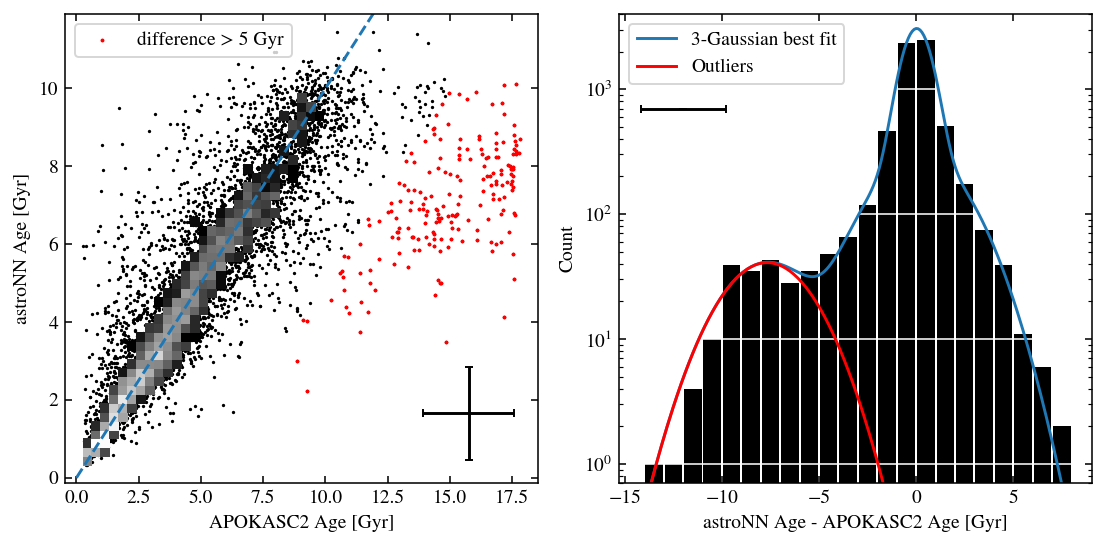

In [2]:
ages, low_age = get_discrepant_ages(stellar_params, diff_cut=-5)
low_age.to_csv('age_discrep.csv')

# APOKASC age vs astroNN age
fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

ax = axs[0]
scatter_hist(ax, ages['APOKASC2_AGE'], ages['ASTRONN_AGE'])
ax.scatter(low_age['APOKASC2_AGE'], low_age['ASTRONN_AGE'], c='r', s=1, label='difference > 5 Gyr')
plot_rms_err(ax, ages[['APOKASC2_AGE_MERR', 'APOKASC2_AGE_PERR']], ages['ASTRONN_AGE_ERR'], loc='lower right')
ax.legend(loc='upper left')
ax.plot([0, 12], [0, 12], linestyle='--')
ax.set_xlabel('APOKASC2 Age [Gyr]')
ax.set_ylabel('astroNN Age [Gyr]')

# Histrogram of age differences
ax = axs[1]
xmin = -14
xmax = 8
bins = np.linspace(xmin, xmax, xmax-xmin+1)
y, x, _ = ax.hist(ages['AGE_DIFF'], color='k', bins=bins, rwidth=0.9)
ax.grid(which='major', axis='y', color='w')
plot_rms_err(ax, ages[['AGE_DIFF_MERR', 'AGE_DIFF_PERR']], [0], loc=(-12, 700))

def trimodal_norm(x, loc1, scale1, a1, loc2, scale2, a2, loc3, scale3, a3):
    """Trimodal Gaussian to fit to age difference."""
    return a1 * norm.pdf(x, loc1, scale1) + a2 * norm.pdf(x, loc2, scale2) + a3 * norm.pdf(x, loc3, scale3)

# best fit trimodal normal
x = x[:-1] + (x[1] - x[0])/2
params, cov = curve_fit(trimodal_norm, x, y, p0=(0, 0.5, 5e3, 0, 2, 1e3, -9, 2, 40))
x_fine = np.arange(xmin, xmax, 0.1)
ax.plot(x_fine, trimodal_norm(x_fine, *params), label='3-Gaussian best fit')
# individual distributions
ax.plot(x_fine, params[8] * norm.pdf(x_fine, *params[6:8]), c='r', label='Outliers')
# plot settings
ax.set_yscale('log')
ax.set_xlabel('astroNN Age - APOKASC2 Age [Gyr]')
ax.set_ylabel('Count')
ax.set_ylim((7e-1, 4e3))
ax.legend()

plt.savefig('age_diffs.png', dpi=300)
plt.show()

## ASPCAP signal-to-noise

The stars with age discrepancies don't seem to have a significantly lower S/N in ASPCAP than the general population of APOKASC-2 targets.

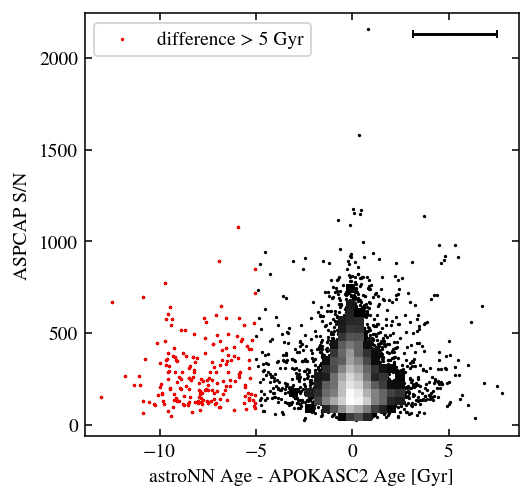

In [3]:
fig, ax = plt.subplots()
scatter_hist(ax, ages['AGE_DIFF'], ages['DR16_ASPCAP_SNR'])
ax.scatter(low_age['AGE_DIFF'], low_age['DR16_ASPCAP_SNR'], s=.6, c='r', label='difference > 5 Gyr')
plot_rms_err(ax, ages[['AGE_DIFF_MERR', 'AGE_DIFF_PERR']], [0], loc='upper right')
ax.set_xlabel('astroNN Age - APOKASC2 Age [Gyr]')
ax.set_ylabel('ASPCAP S/N')
ax.legend()
plt.show()

## Comparison of stellar parameters and age discrepancies

For stars with APOKASC-2 ages (i.e., red giants), astroNN agrees well with parameters determined by APOKASC and ASPCAP. The offset in [O/Fe] is just due to ASPCAP's method for determining alpha abundances. This good agreement does not go away when looking at the stars with age discrepancies, and in fact these stars seem inhabit the same parameter space as the general population - with the notable exception of log(g), and possibly T_eff.

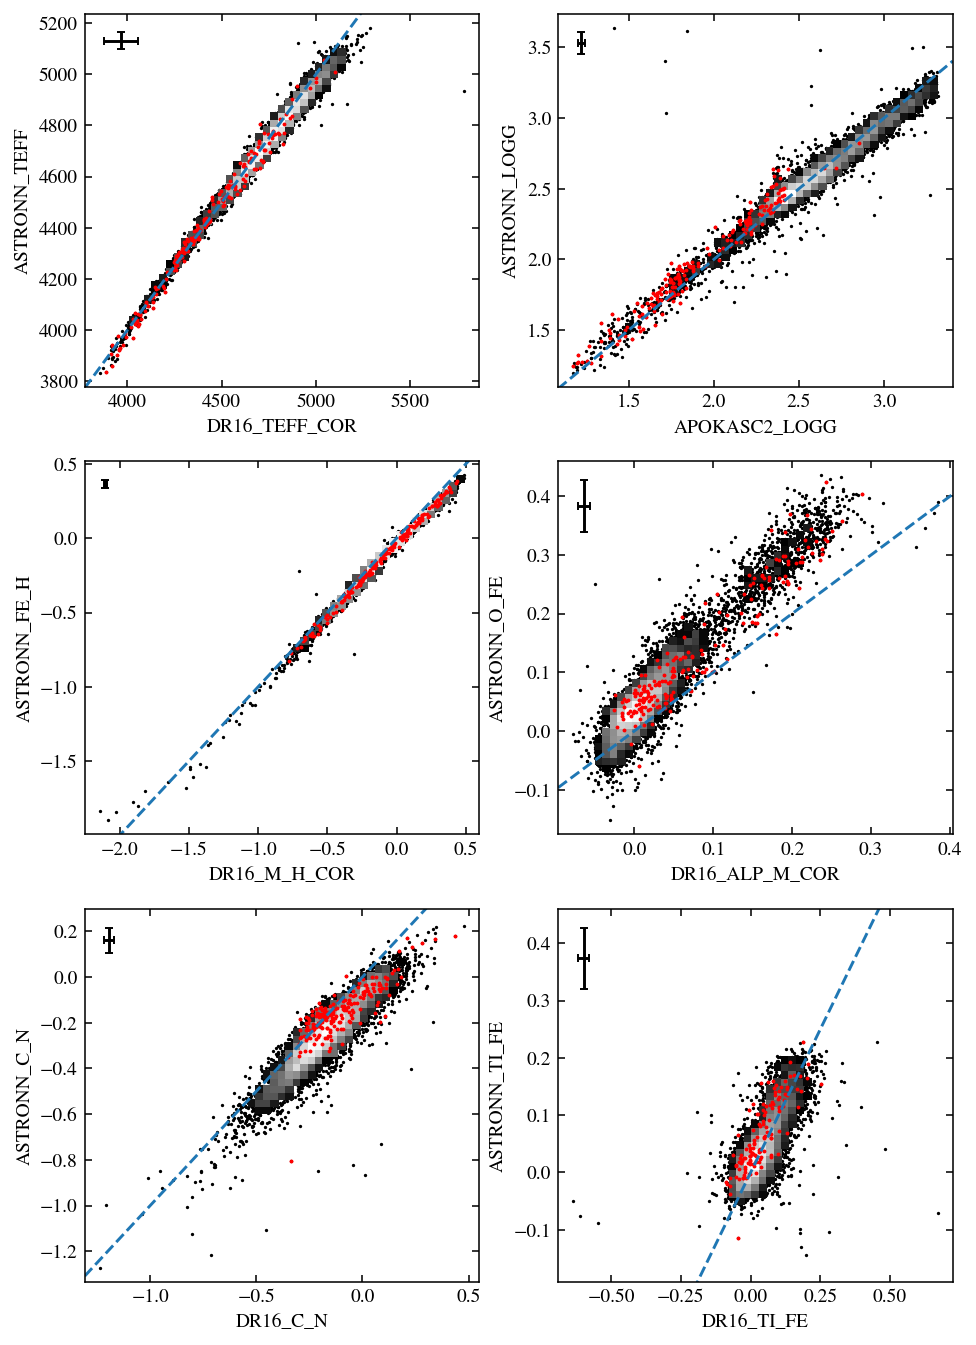

In [8]:
def compare_aspcap_astronn(ax, col1, col2, errcol1=None, errcol2=None, 
                           errloc='upper left', outlier_label=None, legend_loc='best'):
    # Compare the same quantity from APOKASC-2/ASPCAP and astroNN
    if not errcol1:
        errcol1 = col1 + '_ERR'
    if not errcol2:
        errcol2 = col2 + '_ERR'
    scatter_hist(ax, ages[col1], ages[col2])
    ax.scatter(low_age[col1], low_age[col2], c='r', s=1, label=outlier_label)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, xlim, linestyle='--')
    plot_rms_err(ax, ages[errcol1].dropna(), ages[errcol2].dropna(), loc=errloc)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    if outlier_label != None:
        ax.legend(loc=legend_loc)

fig, axs = plt.subplots(3, 2, figsize=(8, 12))
ax = axs[0,0]
compare_aspcap_astronn(ax, 'DR16_TEFF_COR', 'ASTRONN_TEFF')
ax = axs[0,1]
compare_aspcap_astronn(ax, 'APOKASC2_LOGG', 'ASTRONN_LOGG', errcol1='APOKASC2_LOGG_RANERR')
ax = axs[1,0]
compare_aspcap_astronn(ax, 'DR16_M_H_COR', 'ASTRONN_FE_H')
ax = axs[1,1]
compare_aspcap_astronn(ax, 'DR16_ALP_M_COR', 'ASTRONN_O_FE')
ax = axs[2,0]
compare_aspcap_astronn(ax, 'DR16_C_N', 'ASTRONN_C_N')
ax = axs[2,1]
compare_aspcap_astronn(ax, 'DR16_TI_FE', 'ASTRONN_TI_FE')
plt.show()

Looking at age vs log(g) from APOKASC-2, the reason why the age-discrepant stars populate the low-log(g) regime is just because the age-discrepant stars are all really old in APOKASC, therefore less massive, therefore lower log(g) in their giant phase. This isn't an indication of an actual difference between astroNN and APOKASC in log(g).

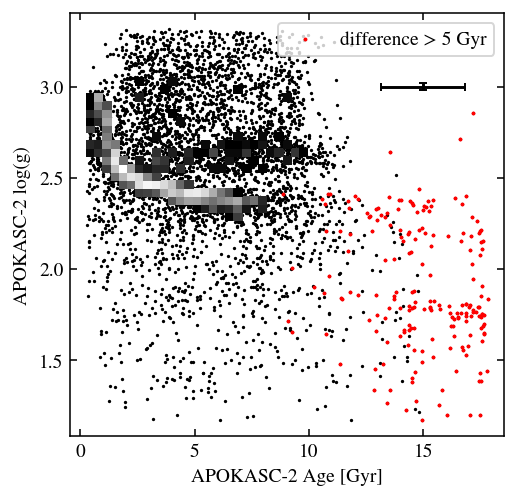

In [5]:
fig, ax = plt.subplots()
scatter_hist(ax, ages['APOKASC2_AGE'], ages['APOKASC2_LOGG'])
ax.scatter(low_age['APOKASC2_AGE'], low_age['APOKASC2_LOGG'], c='r', s=1, label='difference > 5 Gyr')
plot_rms_err(ax, ages[['APOKASC2_AGE_MERR', 'APOKASC2_AGE_PERR']], ages['APOKASC2_LOGG_RANERR'], loc=(15, 3))
ax.legend(loc='upper right')
ax.set_xlabel('APOKASC-2 Age [Gyr]')
ax.set_ylabel('APOKASC-2 log(g)')
plt.show()

Looking more closely at the age vs [C/N] plot, 

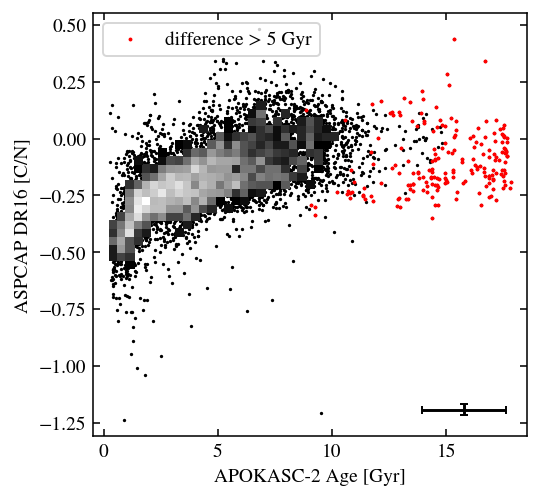

In [6]:
fig, ax = plt.subplots()
scatter_hist(ax, ages['APOKASC2_AGE'], ages['DR16_C_N'])
ax.scatter(low_age['APOKASC2_AGE'], low_age['DR16_C_N'], c='r', s=1, label='difference > 5 Gyr')
plot_rms_err(ax, ages[['APOKASC2_AGE_MERR', 'APOKASC2_AGE_PERR']], ages['DR16_C_N_ERR'], loc='lower right')
ax.legend()
ax.set_xlabel('APOKASC-2 Age [Gyr]')
ax.set_ylabel('ASPCAP DR16 [C/N]')
plt.show()

## *Gaia* and ASPCAP CMD

The age-discrepant stars seem to mostly lie along the RGB rather than on the red clump.

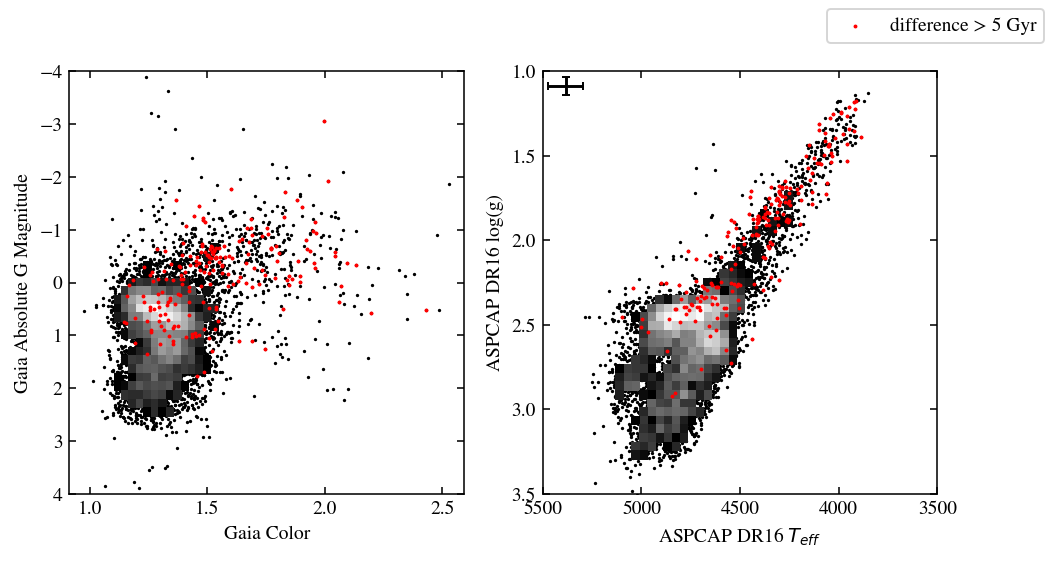

In [10]:
cmd = get_gaia_cmd(stellar_params)
cmd_ages, cmd_low_age = get_discrepant_ages(cmd, diff_cut=-5)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Gaia CMD
ax = axs[0]
scatter_hist(ax, cmd_ages['GAIA_COLOR'], cmd_ages['GAIA_ABS_MAG'], ylim=(-4, 4))
ax.scatter(cmd_low_age['GAIA_COLOR'], cmd_low_age['GAIA_ABS_MAG'], 
           c='r', s=1, label='difference > 5 Gyr')
ax.set_ylim((4, -4))
ax.set_xlabel('Gaia Color')
ax.set_ylabel('Gaia Absolute G Magnitude')

# ASPCAP parameter CMD
ax = axs[1]
scatter_hist(ax, ages['DR16_TEFF_COR'], ages['DR16_LOGG_COR'], 
             xlim=(3500, 5500), ylim=(1, 3.5))
ax.scatter(low_age['DR16_TEFF_COR'], low_age['DR16_LOGG_COR'], c='r', s=1)
plot_rms_err(ax, ages['DR16_TEFF_COR_ERR'], ages['DR16_LOGG_COR_ERR'], loc='lower right')
ax.set_xlim((5500, 3500))
ax.set_ylim((3.5, 1))
ax.set_xlabel('ASPCAP DR16 $T_{eff}$')
ax.set_ylabel('ASPCAP DR16 log(g)')

fig.legend()
plt.show()